In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [2]:
import os

data_dir = 'jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [3]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [4]:
float_data

array([[ 9.9652e+02, -8.0200e+00,  2.6540e+02, ...,  1.0300e+00,
         1.7500e+00,  1.5230e+02],
       [ 9.9657e+02, -8.4100e+00,  2.6501e+02, ...,  7.2000e-01,
         1.5000e+00,  1.3610e+02],
       [ 9.9653e+02, -8.5100e+00,  2.6491e+02, ...,  1.9000e-01,
         6.3000e-01,  1.7160e+02],
       ...,
       [ 9.9982e+02, -3.1600e+00,  2.7001e+02, ...,  1.0800e+00,
         2.0000e+00,  2.1520e+02],
       [ 9.9981e+02, -4.2300e+00,  2.6894e+02, ...,  1.4900e+00,
         2.1600e+00,  2.2580e+02],
       [ 9.9982e+02, -4.8200e+00,  2.6836e+02, ...,  1.2300e+00,
         1.9600e+00,  1.8490e+02]])

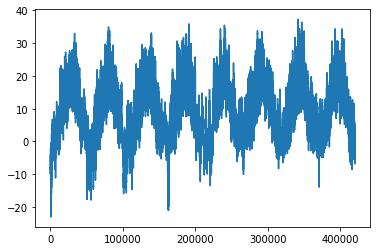

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

In [6]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [7]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [8]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size


In [9]:
train_gen

<generator object generator at 0x7efc1f1dd830>

In [10]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


In [11]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
500/500 [==============================] - 14s 29ms/step - loss: 1.6717 - val_loss: 0.9355
Epoch 2/20
500/500 [==============================] - 8s 16ms/step - loss: 0.5775 - val_loss: 0.3422
Epoch 3/20
500/500 [==============================] - 8s 16ms/step - loss: 0.3107 - val_loss: 0.3200
Epoch 4/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2727 - val_loss: 0.3103
Epoch 5/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2574 - val_loss: 0.3293
Epoch 6/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2497 - val_loss: 0.3021
Epoch 7/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2400 - val_loss: 0.3318
Epoch 8/20
500/500 [==============================] - 8s 15ms/step - loss: 0.2348 - val_loss: 0.3053
Epoch 9/20
500/500 [==============================] - 7s 15ms/step - lo

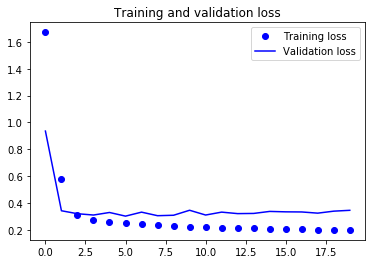

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/5
500/500 [==============================] - 167s 335ms/step - loss: 0.3125 - val_loss: 0.2671
Epoch 2/5
500/500 [==============================] - 169s 337ms/step - loss: 0.2836 - val_loss: 0.2657
Epoch 3/5
500/500 [==============================] - 165s 330ms/step - loss: 0.2753 - val_loss: 0.2649
Epoch 4/5
500/500 [==============================] - 165s 331ms/step - loss: 0.2726 - val_loss: 0.2636
Epoch 5/5
500/500 [==============================] - 167s 335ms/step - loss: 0.2683 - val_loss: 0.2697


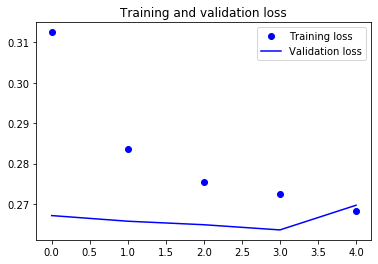

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Using recurrent dropout to fight overfitting

In [15]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/5
500/500 [==============================] - 189s 379ms/step - loss: 0.3432 - val_loss: 0.2786
Epoch 2/5
500/500 [==============================] - 194s 387ms/step - loss: 0.3148 - val_loss: 0.2723
Epoch 3/5
500/500 [==============================] - 194s 389ms/step - loss: 0.3080 - val_loss: 0.2718
Epoch 4/5
500/500 [==============================] - 192s 384ms/step - loss: 0.3054 - val_loss: 0.2701
Epoch 5/5
500/500 [==============================] - 189s 378ms/step - loss: 0.3007 - val_loss: 0.2705


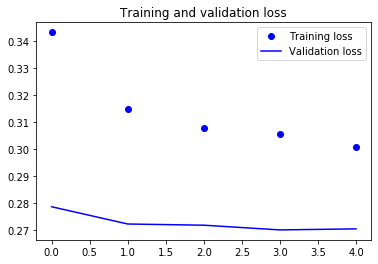

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/5
500/500 [==============================] - 350s 700ms/step - loss: 0.3339 - val_loss: 0.2762
Epoch 2/5
500/500 [==============================] - 352s 704ms/step - loss: 0.3110 - val_loss: 0.2729
Epoch 3/5
500/500 [==============================] - 352s 704ms/step - loss: 0.3069 - val_loss: 0.2718
Epoch 4/5
500/500 [==============================] - 352s 704ms/step - loss: 0.3029 - val_loss: 0.2725
Epoch 5/5
500/500 [==============================] - 351s 702ms/step - loss: 0.2965 - val_loss: 0.2771


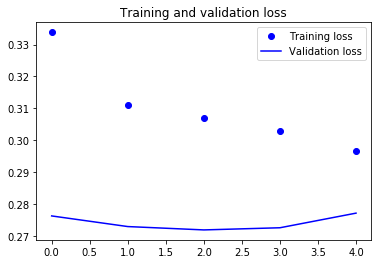

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Using bidirectional RNNs

In [19]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [20]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

Epoch 1/20
496/500 [============================>.] - ETA: 1s - loss: 0.4780

KeyboardInterrupt: 

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words (among top max_features most common words)
maxlen = 500

# Load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 102s 5ms/step - loss: 0.4874 - acc: 0.7684 - val_loss: 0.3609 - val_acc: 0.8598
Epoch 2/10
20000/20000 [==============================] - 100s 5ms/step - loss: 0.3151 - acc: 0.8791 - val_loss: 0.4307 - val_acc: 0.8044
Epoch 3/10
20000/20000 [==============================] - 97s 5ms/step - loss: 0.2515 - acc: 0.9077 - val_loss: 0.3352 - val_acc: 0.8596
Epoch 4/10
20000/20000 [==============================] - 100s 5ms/step - loss: 0.2174 - acc: 0.9223 - val_loss: 0.3709 - val_acc: 0.8794
Epoch 5/10
20000/20000 [==============================] - 100s 5ms/step - loss: 0.1914 - acc: 0.9318 - val_loss: 0.3324 - val_acc: 0.8660
Epoch 6/10
20000/20000 [==============================] - 100s 5ms/step - loss: 0.1763 - acc: 0.9371 - val_loss: 0.3794 - val_acc: 0.8678
Epoch 7/10
20000/20000 [==============================] - 99s 5ms/step - loss: 0.1544 - acc: 0.9453 - val_loss: 0.4044 - val

In [22]:
from keras import backend as K
K.clear_session()

In [23]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 188s 9ms/step - loss: 0.5600 - acc: 0.7172 - val_loss: 0.3628 - val_acc: 0.8646
Epoch 2/10
20000/20000 [==============================] - 185s 9ms/step - loss: 0.3328 - acc: 0.8726 - val_loss: 0.3577 - val_acc: 0.8638
Epoch 3/10
20000/20000 [==============================] - 183s 9ms/step - loss: 0.2690 - acc: 0.9003 - val_loss: 0.3331 - val_acc: 0.8838
Epoch 4/10
 1024/20000 [>.............................] - ETA: 2:43 - loss: 0.1925 - acc: 0.9238

KeyboardInterrupt: 